# Dengue Cases Prediction for Minas Gerais - SARIMAX Model

## Introduction

This notebook implements a hybrid forecasting model for dengue cases in states of Brazil, by time series analysis (SARIMAX). The approach leverages both temporal patterns and external covariates to improve prediction accuracy.

## Methodology Overview

1. **Data Preparation**: Aggregation of weekly dengue cases and climatic variables
2. **Exploratory Data Analysis**: Statistical analysis and visualization of patterns
3. **Time Series Decomposition**: Seasonal-Trend decomposition using LOESS (STL)
4. **Stationarity Testing**: Augmented Dickey-Fuller test for unit root detection
5. **SARIMAX Modeling**: Seasonal ARIMA with external regressors


# Libraries importing

In [1]:
import mosqlient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

## 2. Data Extraction from InfoDengue API

This cell extracts dengue surveillance data from the InfoDengue API for Minas Gerais state from 2016 to 2025. The InfoDengue system provides:

- **Epidemiological data**: Weekly dengue cases, population, receptivity index
- **Climatic variables**: Temperature (min, avg, max) and humidity (min, avg, max)

In [2]:
api_key = "rick0110:414cf362-4ca0-4a50-84ff-e432ff083471"
df = mosqlient.get_infodengue(
    api_key=api_key,
    disease="dengue",
    uf="RJ",
    start_date="2016-02-01",
    end_date="2025-04-01"
)

100%|██████████| 146/146 [00:33<00:00,  4.35requests/s]


## 3. Data Preview and Structure

This cell displays the first few rows of the raw dataset to understand:
- **Data structure**: Column names, data types, and format
- **Temporal resolution**: Weekly epidemiological weeks (SE)
- **Geographical coverage**: Municipal-level data for Minas Gerais
- **Variable completeness**: Identification of missing values

The raw data contains municipal-level observations that need aggregation to state-level for time series modeling.

In [3]:
df

,data_iniSE,SE,casos_est,casos_est_min,casos_est_max,casos,municipio_geocodigo,p_rt1,p_inc100k,Localidade_id,...,nivel_inc,umidmed,umidmin,tempmed,tempmax,casprov,casprov_est,casprov_est_min,casprov_est_max,casconf
0,2025-03-30,202514,15.0,15,15.0,15,3300506,0.988182,53.255700,0,...,2,85.520986,68.006800,21.921800,25.503257,8.0,None,None,None,None
1,2025-03-30,202514,5.0,5,5.0,5,3305802,0.795393,2.644999,0,...,1,85.519914,67.916786,21.095343,24.768357,2.0,None,None,None,None
2,2025-03-30,202514,12.0,12,12.0,12,3300803,0.000415,22.268822,0,...,1,85.177657,68.511643,24.005300,27.783186,1.0,None,None,None,None
3,2025-03-30,202514,69.0,69,69.0,69,3306107,0.000243,95.483230,0,...,2,84.878714,67.844243,22.572143,26.378000,40.0,None,None,None,None
4,2025-03-30,202514,6.0,6,6.0,6,3301603,0.675699,54.044315,0,...,1,82.405986,65.965114,22.604486,26.086886,0.0,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43971,2016-02-07,201606,48.0,48,48.0,48,3305208,0.000720,45.262096,0,...,2,73.615386,55.428571,28.208791,31.571429,47.0,None,None,None,None
43972,2016-02-07,201606,3.0,3,3.0,3,3303005,0.000011,11.048096,0,...,0,73.097711,51.285714,28.809952,32.857143,1.0,None,None,None,None
43973,2016-02-07,201606,27.0,27,27.0,27,3302502,0.091621,10.956325,0,...,1,70.732522,49.571429,27.479546,31.571429,1.0,None,None,None,None
43974,2016-02-07,201606,10.0,10,10.0,10,3302007,0.611347,7.417352,0,...,1,73.296538,53.285714,26.869783,32.142857,3.0,None,None,None,None


## 4. Data Aggregation and Preprocessing

This cell performs data aggregation from municipal to state level:

### Aggregation Strategy:
- **Cases**: Sum across all municipalities (total state cases)
- **Climatic variables**: Mean across municipalities (representative state values)
- **Population**: Mean population (for rate calculations)
- **Receptivity**: Mean receptivity index (average vector suitability)

### Data Quality Considerations:
- Consistent temporal resolution (weekly)
- Standardized column naming for analysis
- Preservation of time series continuity

In [4]:
vars_selected = ['data_iniSE','casos', 'receptivo', 'tempmin', 'tempmed', 'tempmax', 'umidmin', 'umidmed', 'umidmax']

df['data_iniSE'] = pd.to_datetime(df['data_iniSE'], format='%Y-%m-%d')
df_grouped = df.groupby(['data_iniSE'])
dic = {}
dic['data_iniSE'] = df_grouped['data_iniSE'].first()
dic['cases'] = df_grouped['casos'].sum()
for vars in vars_selected[2:]:
    dic[vars] = df_grouped[vars].mean()
df_sel_weekly = pd.DataFrame(dic)
df_sel_weekly = df_sel_weekly.reset_index(drop=True)
df_sel_weekly.columns = ['date', 'cases', 'receptive', 'temp_min', 'temp_avg', 'temp_max', 'humidity_min', 'humidity_avg', 'humidity_max']

## 5. Aggregated Data Preview

The aggregated dataset represents weekly dengue dynamics at state level, suitable for this time series modeling.

In [5]:
df_sel_weekly.head()

,date,cases,receptive,temp_min,temp_avg,temp_max,humidity_min,humidity_avg,humidity_max
0,2016-02-07,5128,0.836957,23.434006,27.557506,32.046843,52.698240,73.528896,93.104037
1,2016-02-14,5926,0.891304,24.034161,25.197529,26.540373,79.153727,86.645878,92.440994
2,2016-02-21,5300,0.858696,24.357660,25.474645,26.964803,78.818323,85.849763,91.450828
3,2016-02-28,5128,0.804348,23.600759,24.775907,26.101045,76.186411,84.261116,90.315331
4,2016-03-06,5185,0.869565,24.399758,25.477794,26.473868,80.555749,86.066951,90.742160


## 6. Data Quality Assessment

This cell performs comprehensive data quality evaluation:

### Statistical Properties:
- **Data types**: Verification of numeric vs. categorical variables
- **Unique values**: Assessment of variable diversity and potential outliers
- **Missing values**: Identification of data gaps that could affect time series continuity

In [6]:
for col in df_sel_weekly.columns:
    print(f'{col}: {df_sel_weekly[col].dtype}')
    print(f'Unique values in {col}: {df_sel_weekly[col].nunique()}')
    print(f'Missing values in {col}: {df_sel_weekly[col].isnull().sum()}')
    print("".join(['=']*20))

date: datetime64[ns]
Unique values in date: 478
Missing values in date: 0
cases: int64
Unique values in cases: 392
Missing values in cases: 0
receptive: float64
Unique values in receptive: 74
Missing values in receptive: 0
temp_min: float64
Unique values in temp_min: 478
Missing values in temp_min: 0
temp_avg: float64
Unique values in temp_avg: 465
Missing values in temp_avg: 13
temp_max: float64
Unique values in temp_max: 465
Missing values in temp_max: 13
humidity_min: float64
Unique values in humidity_min: 465
Missing values in humidity_min: 13
humidity_avg: float64
Unique values in humidity_avg: 465
Missing values in humidity_avg: 13
humidity_max: float64
Unique values in humidity_max: 465
Missing values in humidity_max: 13


## 7. Exploratory Data Analysis - Distribution Analysis

This cell visualizes the distribution of each variable to understand:

### Distribution Characteristics:
- **Skewness**: Asymmetry in variable distributions (common in count data)
- **Kurtosis**: Tail heaviness and outlier presence
- **Modality**: Single vs. multiple peaks in distributions

### Epidemiological Insights:
- **Case distribution**
- **Climatic variables**
The histograms with kernel density estimation (KDE) provide smooth distribution approximations.

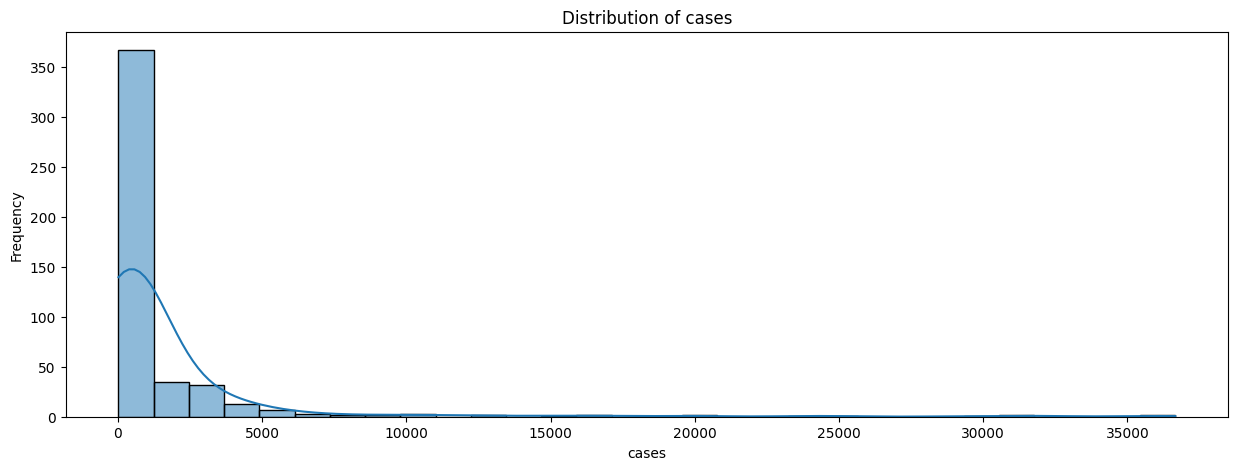

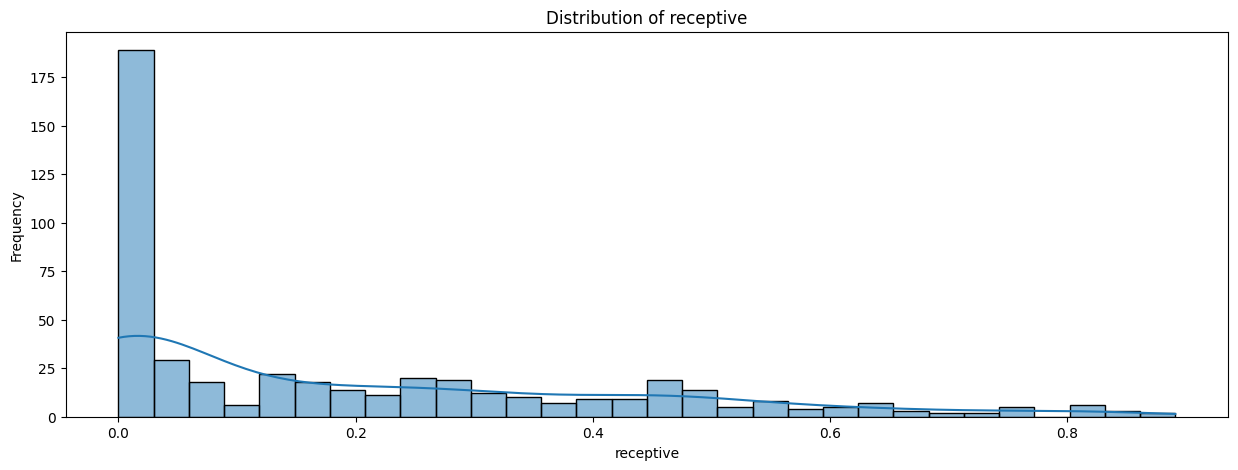

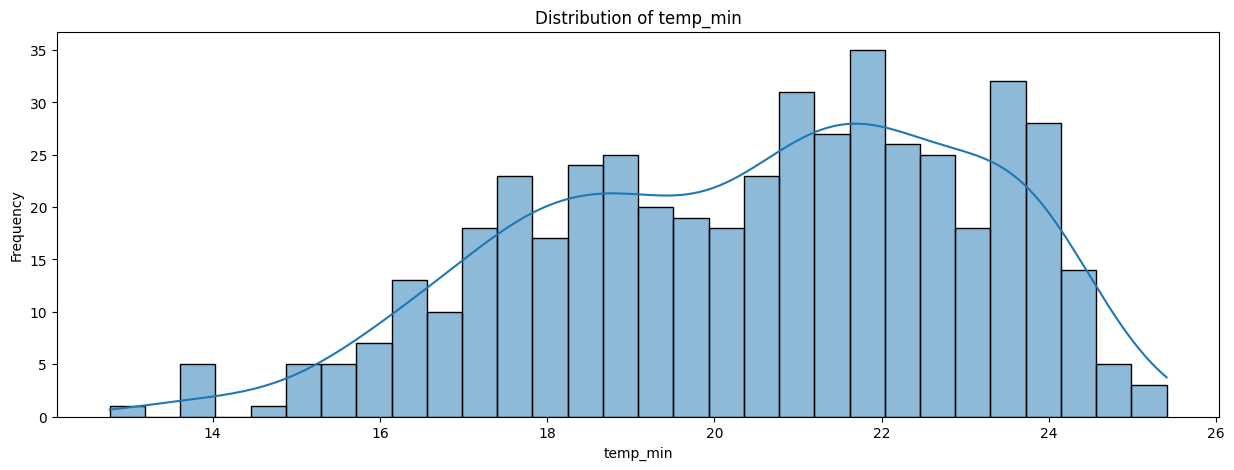

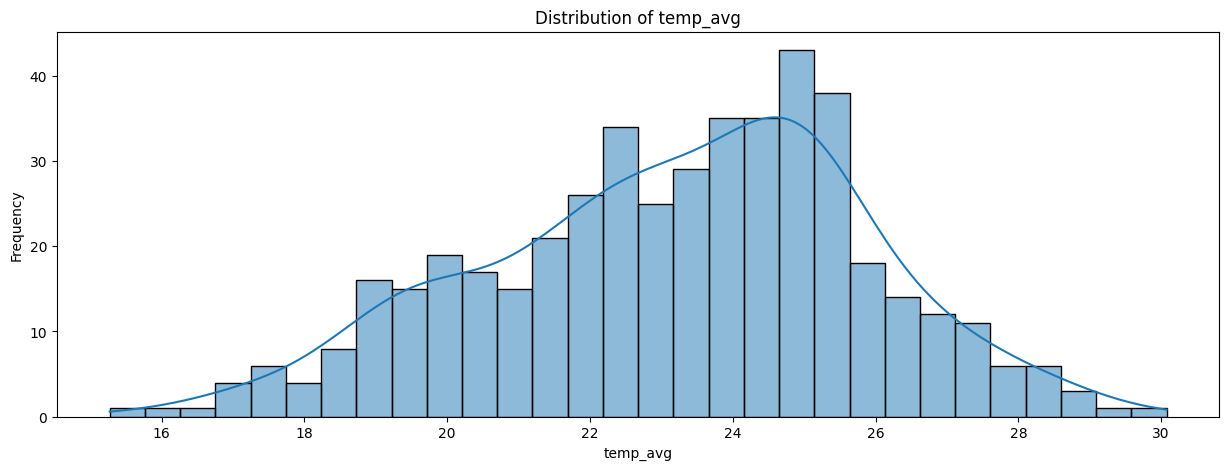

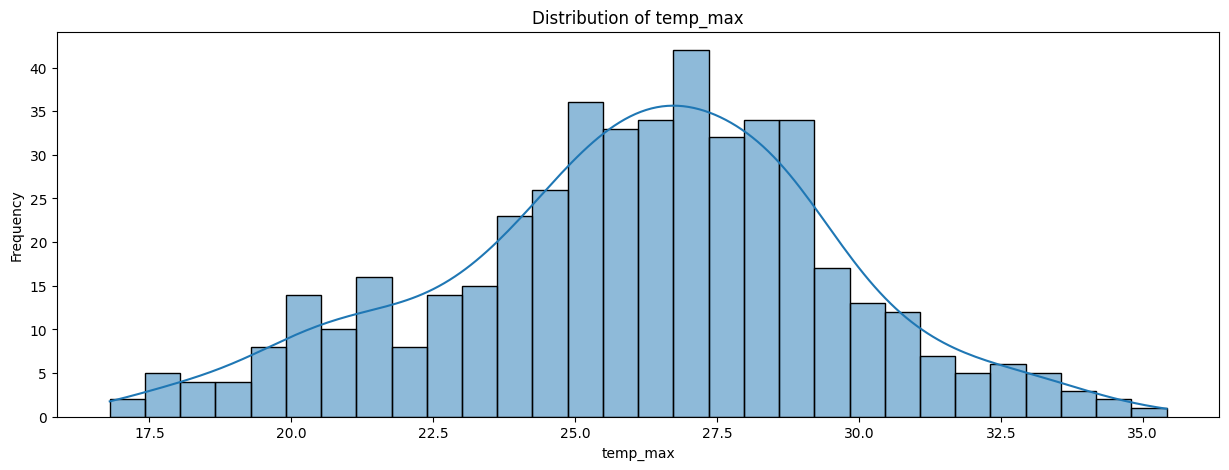

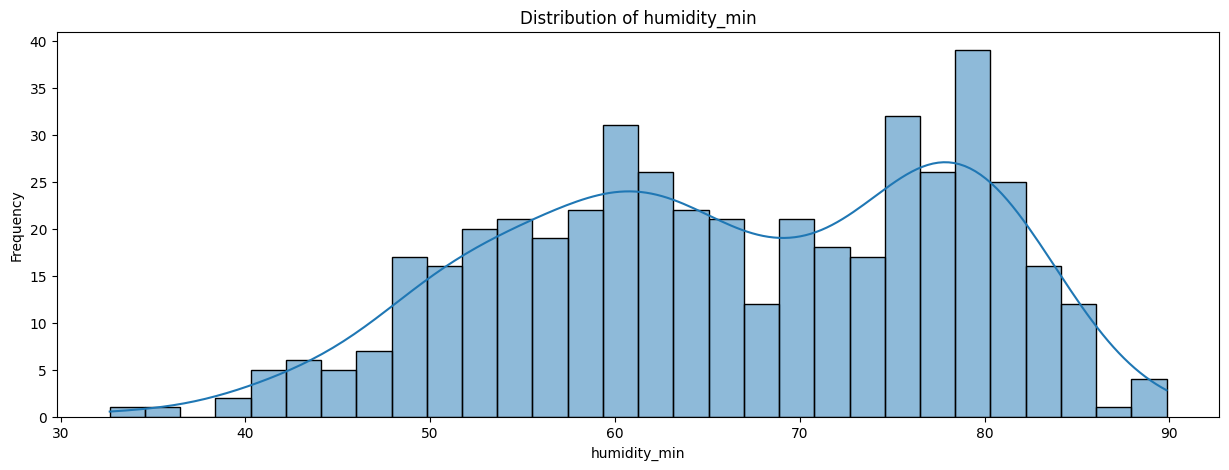

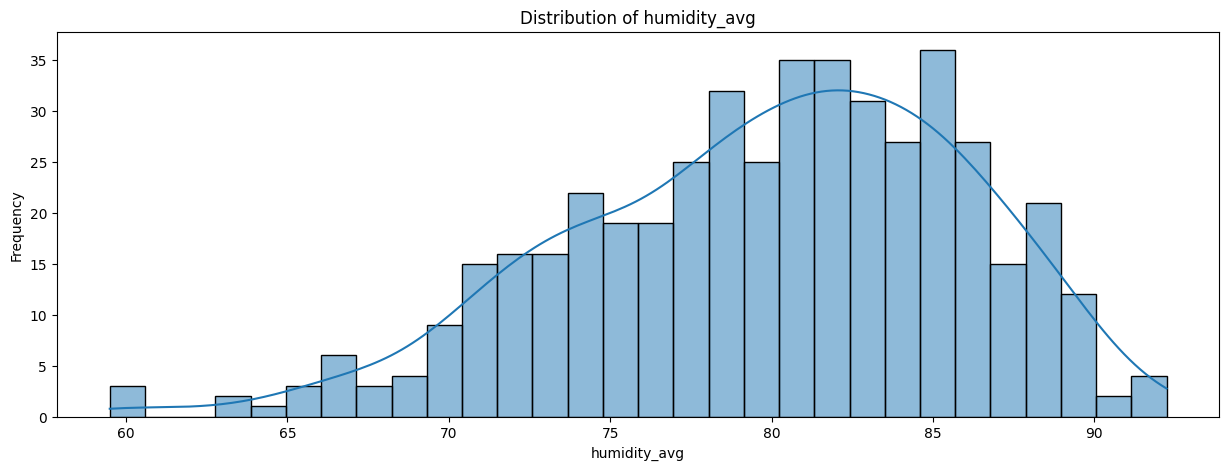

In [7]:
for col in df_sel_weekly.columns[1:-1]:  
    plt.figure(figsize=(15, 5))
    sns.histplot(df_sel_weekly[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

## 8. Correlation Analysis

This cell creates a correlation heatmap to identify relationships between variables:

### Correlation Interpretation:
- **Pearson correlation**: Linear relationships between variables (-1 to +1)
- **Strong correlations** (|r| > 0.7): Indicate potential multicollinearity
- **Moderate correlations** (0.3 < |r| < 0.7): Meaningful associations
- **Weak correlations** (|r| < 0.3): Limited linear relationship

<Axes: >

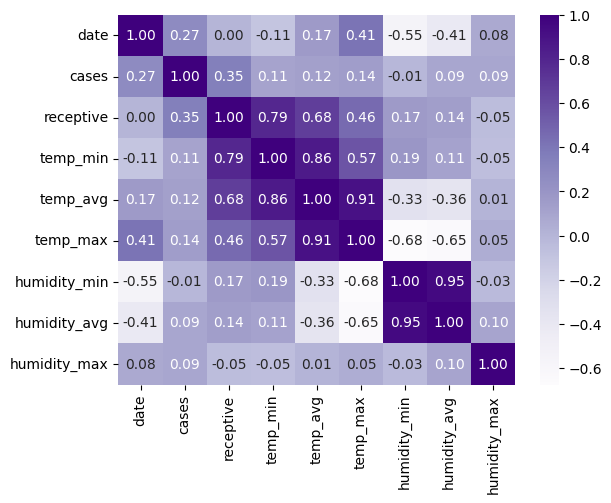

In [8]:
sns.heatmap(df_sel_weekly.corr(), cmap='Purples', annot=True, fmt='.2f')

As in this case we have no variables with a satisfatory linear relationship with cases, we will use only cases variable in this time serie modeling.

## 9. Time Series Visualization with Rolling Statistics

This cell creates time series plots with rolling statistics (moving averages) to identify:

### Temporal Patterns:
- **Seasonality**: Annual cycles in dengue transmission
- **Trends**: Long-term increases or decreases
- **Volatility**: Variability changes over time
- **Outliers**: Unusual spikes or drops

### Rolling Statistics Benefits:
- **Smoothing**: Reduces noise to reveal underlying patterns
- **Trend identification**: Rolling mean shows directional changes
- **Volatility assessment**: Rolling standard deviation shows stability

### Window Size Selection:
- **3-week window**: Balances smoothing with responsiveness
- **Short-term patterns**: Captures recent changes
- **Noise reduction**: Filters out random fluctuations

### Epidemiological Insights:
- **Peak timing**: Identifies high-transmission periods
- **Seasonal amplitude**: Magnitude of seasonal variation
- **Inter-annual variability**: Year-to-year differences in patterns

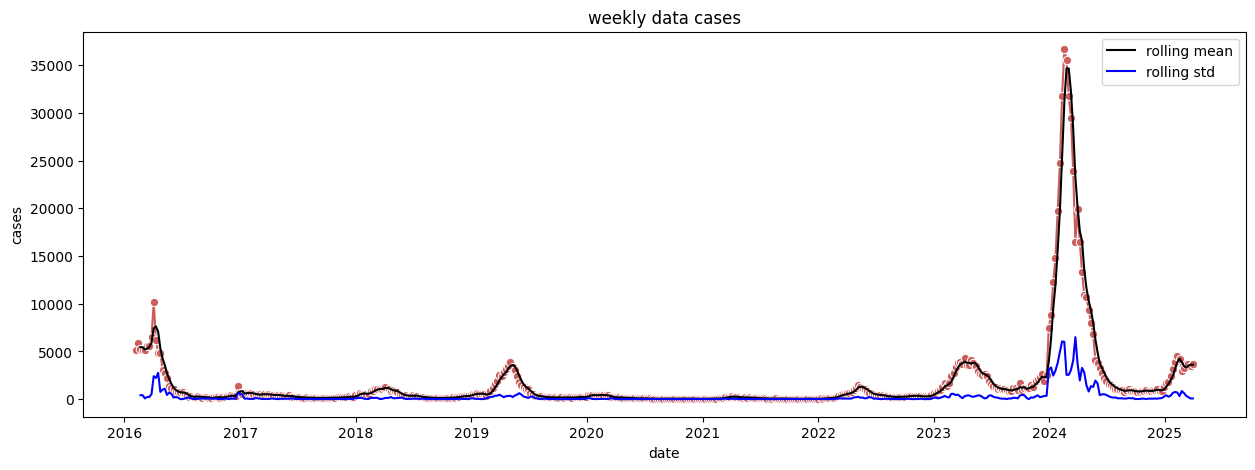

In [9]:
window_rolling = 3
col = 'cases'
plt.figure(figsize=(15, 5))
sns.lineplot(x='date', y=col, data=df_sel_weekly, marker='o', color='indianred')
sns.lineplot(x=df_sel_weekly.date, y=df_sel_weekly[col].rolling(window_rolling).mean(), color='black', label='rolling mean')
sns.lineplot(x=df_sel_weekly.date, y=df_sel_weekly[col].rolling(window_rolling).std(), color='blue', label='rolling std')
plt.title(f'weekly data {col}')
plt.show()
    
    

## 10. STL Decomposition (Seasonal-Trend decomposition using LOESS)

This cell performs STL decomposition on log-transformed and differenced dengue cases:

### Mathematical Framework:
- **STL decomposition**: $X_t = T_t + S_t + R_t$
  - $T_t$: Trend component
  - $S_t$: Seasonal component  
  - $R_t$: Residual component

### Preprocessing Steps:
- **Log transformation**: $\log(cases + 0.1)$ to stabilize variance
- **First differencing**: $\Delta X_t = X_t - X_{t-1}$ to achieve stationarity

### STL Parameters:
- **Period**: 52 weeks (annual seasonality)
- **Trend**: 101 weeks (long-term trend estimation)
- **Robust**: True (resistant to outliers)

### Statistical Benefits:
- **Variance stabilization**: Log transformation reduces heteroscedasticity
- **Stationarity**: Differencing removes trend and some seasonality
- **Outlier robustness**: Robust estimation minimizes outlier impact

### Interpretation:
- **Trend**: Long-term changes in dengue incidence
- **Seasonal**: Regular annual patterns
- **Residual**: Irregular fluctuations and noise

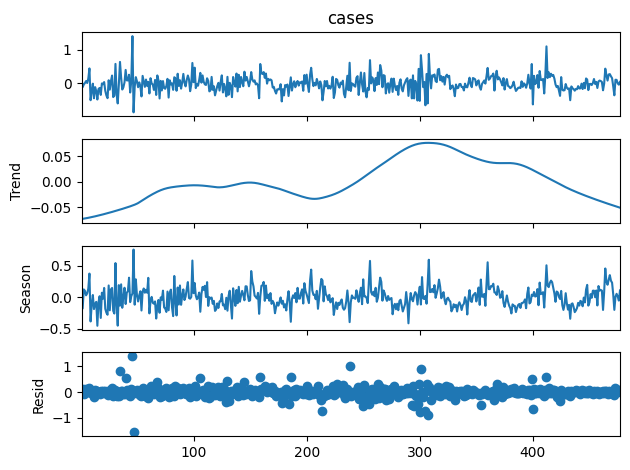

In [10]:
decomp = STL(np.log(df_sel_weekly['cases']).diff(1).dropna(), period=52, trend=101, robust=True).fit()
decomp.plot()
plt.show()


## 11. Data Sorting for Time Series Analysis

This cell ensures proper temporal ordering of the dataset:

In [11]:
df_sel_weekly.sort_values(by='date', inplace=True)

## 12. Stationarity Testing and Residual Diagnostics

This cell performs critical statistical tests on the STL residuals:

### Augmented Dickey-Fuller (ADF) Test:
- **Null hypothesis**: Series has unit root (non-stationary)
- **Alternative**: Series is stationary
- **Decision rule**: p-value < 0.05 → reject null (stationary)
- **Mathematical form**: $\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \sum_{i=1}^{p} \delta_i \Delta y_{t-i} + \epsilon_t$

### Ljung-Box Test:
- **Purpose**: Tests for autocorrelation in residuals
- **Null hypothesis**: Residuals are independently distributed
- **Test statistic**: $Q_{LB} = n(n+2)\sum_{k=1}^{h} \frac{\hat{\rho}_k^2}{n-k}$
- **Critical for**: Ensuring residuals are white noise

### Autocorrelation Function (ACF):
- **Visual inspection**: Pattern of autocorrelations
- **Significance bounds**: 95% confidence intervals
- **Interpretation**: Significant lags indicate remaining structure

### Statistical Requirements:
- **Stationarity**: Essential for ARIMA modeling
- **White noise residuals**: Confirms model adequacy
- **No autocorrelation**: Validates decomposition effectiveness

ADF p-value: 6.639255523446275e-15
Ljung-Box p-value: [1.46536718e-08 2.77103508e-08 5.19782289e-08 1.40868842e-08
 1.41558887e-10 2.33776807e-10 2.80276728e-10 1.27263543e-10
 3.72099179e-10 4.37945749e-10]


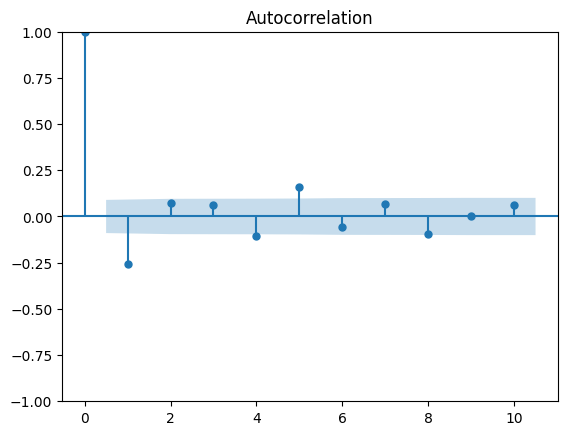

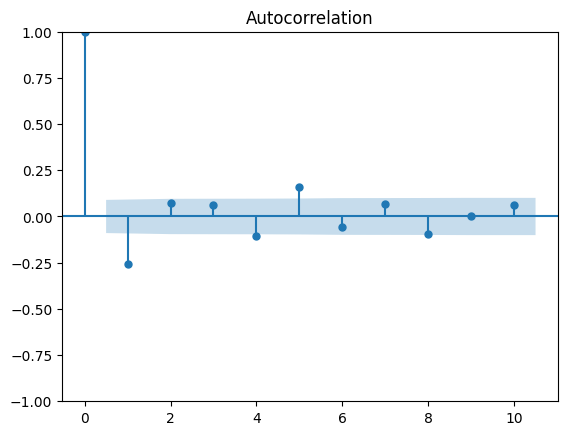

In [12]:
adf = adfuller(decomp.resid)
ljung = acorr_ljungbox(decomp.resid, lags=10)
print(f'ADF p-value: {adf[1]}')
print(f'Ljung-Box p-value: {ljung["lb_pvalue"].values}')
plot_acf(decomp.resid, lags=10)

We can see that in some states the residual have autocorrelation. But we will follow with Sarimax model.

## 14. Train-Test Split for Time Series

This cell implements temporal train-test splitting for time series validation:

### Temporal Split Strategy:
- **85% training**: Sufficient data for pattern learning
- **21% testing**: Adequate for out-of-sample validation

### Log Transformation:
- **Formula**: $\log(cases + 0.1)$
- **Purpose**: Variance stabilization and normalization
- **Constant addition**: Handles zero values

### Mathematical Properties:
- **Stationarity**: Log transformation often improves stationarity
- **Homoscedasticity**: Reduces variance heterogeneity
- **Normality**: Logarithm approximates normal distribution for positive data

In [13]:
n_train = int(df_sel_weekly.shape[0] * 0.85)
train, test = np.log(df_sel_weekly['cases'].iloc[:n_train]+0.1).values, np.log(df_sel_weekly['cases'].iloc[n_train:]+0.1).values

## 15. SARIMAX Model Implementation

This cell implements the Seasonal ARIMA with eXogenous variables (SARIMAX) model:

### SARIMAX Model Specification:
- **Order**: (2, 1, 1) - Non-seasonal components
  - **AR(2)**: 2 autoregressive terms
  - **I(1)**: 1st order differencing
  - **MA(1)**: 1 moving average term
- **Seasonal Order**: (2, 1, 1, 52) - Seasonal components
  - **SAR(1)**: 1 seasonal autoregressive term
  - **SI(1)**: 1st order seasonal differencing
  - **SMA(1)**: 1 seasonal moving average term
  - **Period**: 52 weeks (annual seasonality)

### Mathematical Formulation:
$y_t = \mu + \sum_{i=1}^{p} \phi_i y_{t-i} + \sum_{j=1}^{P} \Phi_j y_{t-jS} + \sum_{k=1}^{K} \beta_k X_{k,t} + \sum_{l=1}^{q} \theta_l \epsilon_{t-l} + \sum_{m=1}^{Q} \Theta_m \epsilon_{t-mS} + \epsilon_t$


### Model Selection Rationale:
- **Differencing**: Achieves stationarity
- **AR terms**: Captures short-term dependencies
- **MA terms**: Models error autocorrelation
- **Seasonal terms**: Handles annual patterns
- **Weekly seasonality**: Appropriate for epidemiological data

In [14]:
model1 = SARIMAX(train, order=(2, 1, 2), seasonal_order=(2, 1, 2, 52), enforce_invertibility=False, enforce_stationarity=False)
model1_fit = model1.fit()

/home/richa/projects/preditores_da_Picada/preditores_da_Picada/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 16. SARIMAX Forecasting

This cell generates forecasts from the fitted SARIMAX model:

### Forecasting Process:
- **Multi-step ahead**: Forecasts entire test period
- **Exponential transformation**: Converts log-scale predictions back to original scale
- **Out-of-sample**: True forecasting performance evaluation

### Mathematical Transformation:
- **Log-scale forecast**: $\hat{y}_t^{log}$
- **Original scale**: $\hat{y}_t = \exp(\hat{y}_t^{log})$
- **Bias correction**: May need adjustment for log-normal distribution

### Forecast Properties:
- **Point forecasts**: Best estimate of future values
- **Uncertainty**: Inherent in all forecasts
- **Horizon effect**: Accuracy typically decreases with forecast horizon

### Evaluation Preparation:
- **Comparable scales**: Both actual and predicted in original scale
- **Time alignment**: Proper temporal matching for evaluation

## 17. SARIMAX Model Visualization and Validation

This cell creates comprehensive visualizations to assess SARIMAX model performance:

### Visualization Components:
1. **Forecast vs. Actual**: Direct comparison of predicted and observed values
2. **Training Fit**: How well the model captures training data patterns
3. **Temporal Alignment**: Proper time axis for interpretability

### Performance Assessment:
- **Visual inspection**: Pattern matching and systematic errors
- **Forecast accuracy**: Closeness to actual values
- **Seasonal capture**: Model's ability to reproduce seasonal patterns
- **Trend following**: Tracking of long-term changes

### Diagnostic Value:
- **Residual patterns**: Systematic over/under-prediction
- **Seasonal alignment**: Correct timing of seasonal peaks
- **Magnitude accuracy**: Appropriate scale of predictions

### Statistical Validation:
- **Training performance**: In-sample fit quality
- **Forecast performance**: Out-of-sample prediction accuracy
- **Model adequacy**: Overall performance assessment

In [18]:
predictions = np.exp(model1_fit.forecast(steps=len(test)))

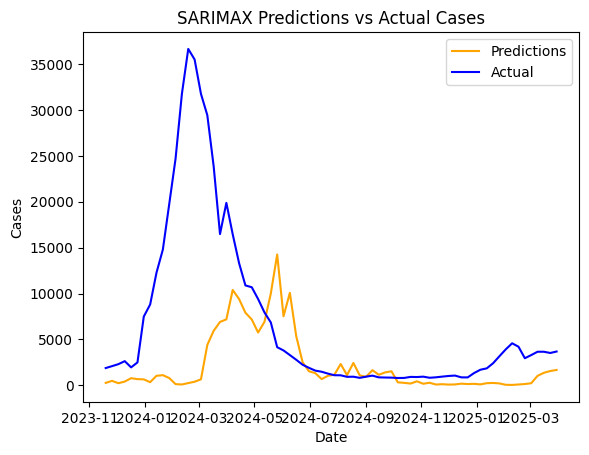

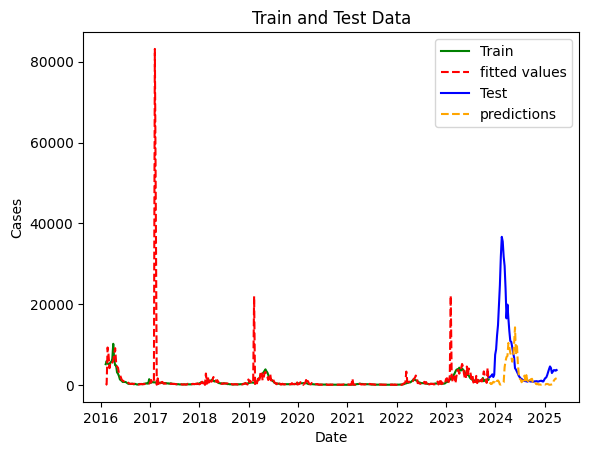

In [19]:
sns.lineplot(x=df_sel_weekly['date'].iloc[n_train:] ,y=predictions, label='Predictions', color='orange')
sns.lineplot(x=df_sel_weekly['date'].iloc[n_train:] ,y=np.exp(test), label='Actual', color='blue')
plt.title('SARIMAX Predictions vs Actual Cases')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.show()

sns.lineplot(x=df_sel_weekly['date'].iloc[:n_train] ,y=np.exp(train), label='Train', color='green')
sns.lineplot(x=df_sel_weekly['date'].iloc[:n_train] ,y=np.exp(model1_fit.fittedvalues), label='fitted values', color='red', linestyle='--')
sns.lineplot(x=df_sel_weekly['date'].iloc[n_train:] ,y=np.exp(test), label='Test', color='blue')
sns.lineplot(x=df_sel_weekly['date'].iloc[n_train:] ,y=predictions, label='predictions', color='orange', linestyle='--')
plt.title('Train and Test Data')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.show()

In [17]:
gc.collect()

NameError: name 'gc' is not defined

In [20]:
import pickle
with open('../../models/RJ_Sarimax_model_R.pkl', 'wb') as f:
    pickle.dump(model1_fit, f)

: 